In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

METADATA = {'Contributor': 'T. Dunn'}
FSIZE = [5,4]
FDPI = 100
SAVEFIGS = True

In [3]:
# DMG functions
def CR_to_XP(CR):
    """Returns the XP value for the given CR
    CR -- real value representation of a monster's challenge rating
    """
    CRs = np.array([0, 1/8, 1/4, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])
    XPs = np.array([0, 25, 50, 100, 200, 450, 700, 1100, 1800, 2300, 2900, 3900, 5000, 
        5900, 7200, 8400, 10000, 11500, 13000, 15000, 18000, 20000, 22000, 25000, 
        33000, 41000, 50000, 62000, 75000, 90000, 105000, 120000, 135000, 155000])
    return XPs[np.where(CRs == CR)]

def encounter_multiplier_DMG(P, N):
    """Returns the encounter multiplier given by the DMG
    P -- integer number of PCs in the encounter
    N -- integer number of NPCs in the encounter
    """
    n_array = np.asarray([1,2,3,7,11,15])
    m_array = np.asarray([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0])
    i = 1 + n_array[n_array <= max(N,1)].argmax()
    if P >= 6:
        i -= 1
    elif P <= 2:
        i += 1
    return m_array[i]

# encounter multiplier approximations that assume all monsters are identical
def encounter_multiplier_approx(P=4, N=1, PD=0, AoE_pct=0, AoE_eff=1.0):
    """Returns the approximate encounter multiplier
    P -- number of PCs in the encounter
    N -- number of NPCs in the encounter
    PD -- number of PCs expected to die during encounter
    AoE_pct -- decimal percent of damage done to each NPC using AoE effects
    AoE_eff -- ratio of AoE DPR per target to single target DPR
    """
    EM = (N + 1)*(1 - AoE_pct)/2 + AoE_pct/AoE_eff
    PD = min(PD, P)
    EM *= 8.0*P/(2*P*P - 2*PD*P + PD*(PD + 1))
    return EM

In [8]:
# XP log functions
def damage_total(XP_log):
    """Returns the total damage done
    XP_log -- list of XP contributions for the encounter
    """
    dmg = 0
    for x in XP_log:
        if x['target'] == x['ally']:
            dmg += x['eHP_delta']
    return dmg

def damage_overflow_total(XP_log):
    """Returns the total damage done in excess of the monsters' effective hit points
    XP_log -- list of XP contributions for the encounter
    """
    dmg = 0
    for x in XP_log:
        if x['target'] == x['ally']:
            dmg += x['damage'] - x['eHP_delta']
    return dmg

def encounter_XP_total(XP_log):
    """Returns the total encounter XP from the XP_log
    XP_log -- list of XP contributions for the encounter
    """
    return np.sum([x['XP'] for x in XP_log])

def encounter_weights(eHPs, eDPRs, XP_log):
    """Returns encounter weight matrix described by the XP_log
    eHPs -- list of effective hit point values
    eDPRs -- list of effective damage per round values
    XP_log -- list of XP contributions for the encounter
    """
    max_XPs = encounter_XP_matrix(eHPs, eDPRs)
    enc_XPs = np.zeros(max_XPs.shape)
    for x in XP_log:
        enc_XPs[x['ally'], x['target']] += x['XP']
    enc_Ws = np.divide(enc_XPs, max_XPs)
    return enc_Ws

def create_XP_log(eHPs, eDPRs, damage):
    """Returns an XP_log
    eHPs -- list of effective hit point values
    eDPRs -- list of effective damage per round values
    damage -- list of damage entries
        damage = [
            {'targets': [1], 'damage': 5, 'efficiency': 1.0, 'color': 'w'},
            {'targets': [0], 'damage': 3, 'efficiency': 1.0, 'color': 'w'}
        ]
    """
    nC = len(eDPRs)
    eDPR_mins = [sum(eDPRs[0:i]) for i in range(nC)]
    eHP_mins = [sum(eHPs[0:i]) for i in range(nC)]
    dmgs = [0]*nC
    eHP_dmgs = [0]*nC
    XP_log = []
    for d in damage:
        # determine if the damage affects a single target or multiple
        if len(d['targets']) > 1:
            dmg_type = 'multiple'
        else:
            dmg_type = 'single'

        # determine which target takes the most damage
        for i in range(nC):
            if (i in d['targets']):
                dmgs[i] = min(eHP_dmgs[i] + d['damage'], eHPs[i]) - eHP_dmgs[i]
            else:
                dmgs[i] = 0
        t_max = np.argmax(dmgs)
        dmg_max = dmgs[t_max]

        # construct log entries for damage
        for i in range(nC):
            if eHP_dmgs[i] < eHPs[i]:
                if i not in d['targets']:
                    dmg = dmg_max
                    t = t_max
                else:
                    dmg = dmgs[i]
                    t = i
                
                XP_log.append({
                    'type': dmg_type,
                    'efficiency': d['efficiency'],
                    'target': t,
                    'ally': i,
                    'damage': d['damage'],
                    'XP': 0.25*dmg*eDPRs[i]/(d['efficiency']),
                    'eHP_min': eHP_mins[t] + eHP_dmgs[t],
                    'eDPR_min': eDPR_mins[i],
                    'eHP_delta': dmg,
                    'eDPR_delta': eDPRs[i],
                    'color': d['color']
                })
        
        # update damage taken
        for t in d['targets']:
            eHP_dmgs[t] += dmgs[t]
        
    return XP_log

def generate_XP_diagram(eHPs, eDPRs, XP_log, **kwargs):
    """Generate XP diagram and returns axes for that diagram
    eHPs -- list of effective hit point values
    eDPRs -- list of effective damage per round values
    XP_log -- list of XP contributions for the encounter
    **kwargs
        fontsize -- font size for the figure's text
        ax -- pyplot axes
    """
    nC = len(eHPs)
    eHP_mins = [sum(eHPs[0:i]) for i in range(len(eHPs))]
    eDPR_mins = [sum(eDPRs[0:i]) for i in range(len(eDPRs))]
    eHP_max = sum(eHPs)
    eDPR_max = sum(eDPRs)

    fontsize = kwargs.get('fontsize', None) # 10 possibly plt.rcParams['font.size']
    ax = kwargs.get('ax', plt.axes())
    title = kwargs.get('title', None)

    # initialize figure
    ax.add_patch(plt.Rectangle((0,0), eDPR_max, eHP_max, fc='white', ec='none', alpha=1.0))

    # apply damage and color XP boxes accordingly
    for x in XP_log:
        ax.add_patch(plt.Rectangle((x['eDPR_min'], x['eHP_min']), x['eDPR_delta'], x['eHP_delta'], 
            fc=x['color'], ec='none', alpha=0.3))

    # create XP box borders
    for i in range(nC):
        for j in range(nC):
            if i == j:
                ls = '-'
            else:
                ls = '-'
            ax.add_patch(plt.Rectangle((eDPR_mins[i], eHP_mins[j]), eDPRs[i], eHPs[j], fc='none', ec='black', linestyle=ls))

    # create XP box labels
    texParam = plt.rcParams['text.usetex']
    plt.rcParams['text.usetex'] = True
    for i in range(nC):
        for j in range(nC):
            ax.text(eDPR_mins[i] + 0.5*eDPRs[i], eHP_mins[j] + 0.5*eHPs[j], 
                r'$\mathit{{XP}}_{{{:},{:}}}$'.format(j+1,i+1), fontsize=fontsize, ha='center')

    # create axes labels
    for i in range(nC):
        ax.text(eDPR_mins[i] + 0.5*eDPRs[i], -(0.7/16)*eHP_max, 
            r'$\mathit{{eDPR}}_{{{:}}}$'.format(i+1), fontsize=fontsize, ha='center', va='center')
        ax.text(-(0.7/16)*eDPR_max, (eHP_mins[i] + 0.5*eHPs[i]), 
            r'$\mathit{{eHP}}_{{{:}}}$'.format(i+1), fontsize=fontsize, ha='center', va='center', rotation='vertical')

    # create title
    if title:
        ax.text(0.5*eDPR_max, eHP_max*(1 + (0.7/16)), title, fontsize=fontsize, ha='center', va='center')
    
    plt.rcParams['text.usetex'] = texParam

    plt.axis('off')
    plt.axis('scaled')

    return ax

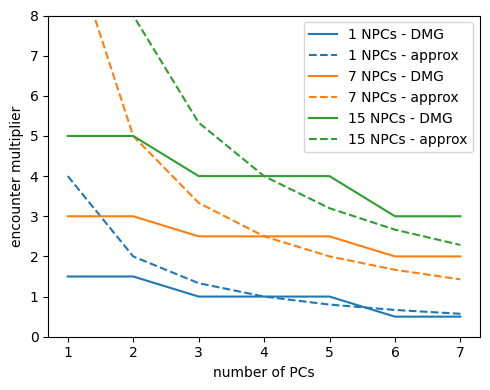

In [17]:
# plots the encounter multiplier vs the number of PCs for three different numbers of NPCs
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(ylim=[0,8], xlabel='number of PCs', ylabel='encounter multiplier') 

P = np.arange(1, 8)

nList = [1, 7, 15]
cList = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i in range(len(nList)):
    n = nList[i]
    color = cList[i]
    y = np.array([encounter_multiplier_DMG(p, n) for p in P ])
    ax.plot(P, y, '-', color=color, label='{:d} NPCs - DMG'.format(n))

    y = np.array([encounter_multiplier_approx(p, 1)*encounter_multiplier_DMG(4, n) for p in P ])
    ax.plot(P, y, '--', color=color, label='{:d} NPCs - approx'.format(n))

ax.legend()

if SAVEFIGS: fig.savefig('./fig-em-vs-pcs.svg', metadata=METADATA)

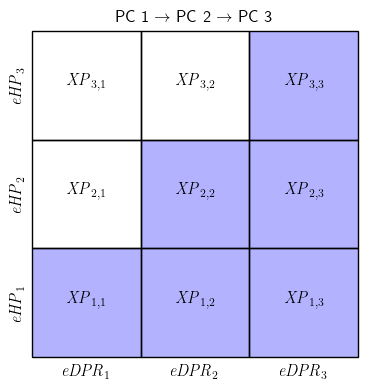

In [16]:
# An example encounter diagram for two NPCs defeated in order using single target damage
eDPRs = [3, 3, 3]
eHPs  = [3, 3, 3]

damage = [
    {'targets': [0], 'damage': 3, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [1], 'damage': 3, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [2], 'damage': 3, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
#ax = plt.axes()
ax = generate_XP_diagram(eHPs, eDPRs, XP_log, title=r'PC 1 $\rightarrow$ PC 2 $\rightarrow$ PC 3', fontsize=12)

if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-three-pcs-single-target.svg', metadata=METADATA)

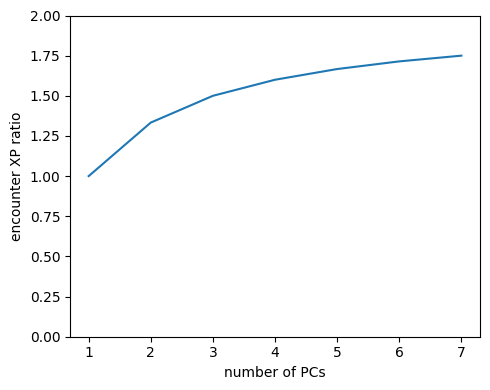

In [18]:
# plots the encounter multiplier vs the number of PCs for three different numbers of NPCs
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(ylim=[0,2], xlabel='number of PCs', ylabel='encounter XP ratio') 

P = np.arange(1, 8)
y = np.array([encounter_multiplier_approx(p, 1, PD=p)/encounter_multiplier_approx(p, 1) for p in P ])
ax.plot(P, y, '-')

#ax.legend()

if SAVEFIGS: fig.savefig('./fig-single-target-em-ratio-vs-pcs.svg', metadata=METADATA)

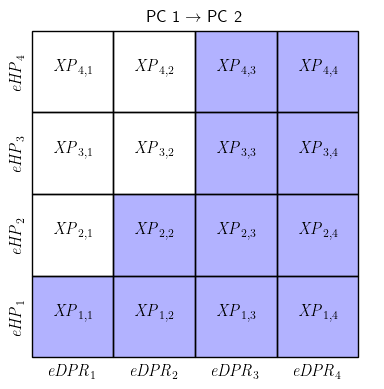

In [18]:
# An example encounter diagram for two NPCs defeated in order using single target damage
eDPRs = [3, 3, 3, 3]
eHPs  = [3, 3, 3, 3]

damage = [
    {'targets': [0], 'damage': 3, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [1], 'damage': 3, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [2], 'damage': 2.99, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [3], 'damage': 2.99, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = generate_XP_diagram(eHPs, eDPRs, XP_log, title=r'PC 1 $\rightarrow$ PC 2', fontsize=12)

if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-pcs-single-target-partial.svg', metadata=METADATA)

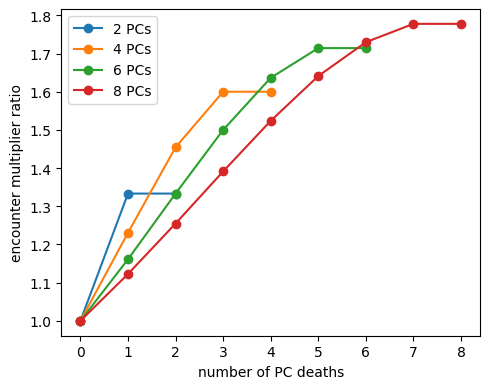

In [37]:
# plots the encounter multiplier vs the number of PCs for three different numbers of NPCs
P = 4


fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlabel='number of PC deaths', ylabel='encounter multiplier ratio') 

P = [2, 4, 6, 8]
for p in P:
    PD = np.arange(0, p+1)
    y = np.array([encounter_multiplier_approx(p, 1, PD=pd)/encounter_multiplier_approx(p, 1, PD=0) for pd in PD ])
    ax.plot(PD, y, '-o', label='{:d} PCs'.format(p))

ax.legend()

if SAVEFIGS: fig.savefig('./fig-single-target-em-ratio-vs-pcs-deaths.svg', metadata=METADATA)